# LSTM - vanilla

In [1]:
best_model = "best_model_all_feat_2layers.pt"

# best_model = "best_model_all_feat_all_agents.pt"

In [2]:
best_model

'best_model_all_feat_2layers.pt'

## Load and prepare data

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [4]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


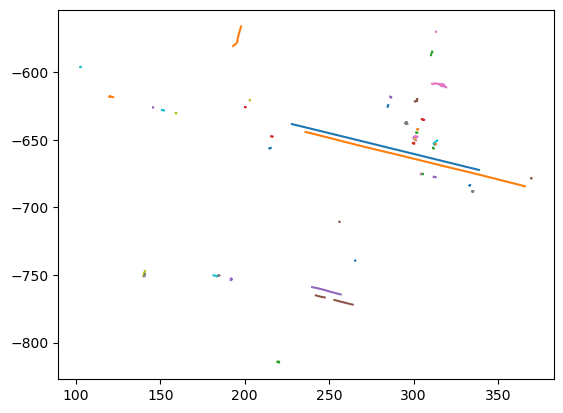

In [5]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [6]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :5].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :5].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future[..., :2] = future[..., :2] @ R
                future[..., 2:4] = future[..., 2:4] @ R
                # future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future[..., :2] = future[..., :2] - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future[..., :4] = future[..., :4] / self.scale

        # future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [7]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [8]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=2, future_steps=60):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Encoder: takes in past trajectory
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder: predicts future positions one step at a time
        self.decoder = nn.LSTM(input_size=5, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, forcing_ratio = 0.5):
    # def forward(self, data):
        x = data.x[..., :5]  # Use position + velocity
        x = x.reshape(-1, 50, 50, self.input_dim)[:, 0, :, :]  # (batch, 50, 5), ego only
        # x = x.reshape(-1, 50, self.input_dim)
        batch_size = x.size(0)
        
        if self.training:
            future = data.y.view(batch_size, 60, self.output_dim) # (batch, 60, 2)

        device = x.device

        # Encode past
        _, (hidden, cell) = self.encoder(x)

        # Initialize decoder input with last observed position
        decoder_input = x[:, -1, :self.output_dim].unsqueeze(1)  # (batch, 1, 2)
        
        # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            # TODO: remove forcing ratio?
            if self.training and random.random() < forcing_ratio:
            # if self.training:
                decoder_input = future[:, t].unsqueeze(1)  # ground truth
                # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
            else:
                decoder_input = pred.detach()  # predicted output as next input
                # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

In [9]:
# # Example of basic model with simple attention mechanism
# class SimpleLSTMWithAttn(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):
#         super(SimpleLSTMWithAttn, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
#         # Simple attention mechanism
#         self.attention = nn.Linear(hidden_dim, 1)
        
#         # Add multi-layer prediction head for better results
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
        
#         # Initialize weights properly
#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 nn.init.xavier_normal_(param)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0.0)
        
#     def forward(self, data):
#         x = data.x[..., :5]
#         x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
#         x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
#         # Process through LSTM
#         lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        
#         # Apply attention mechanism
#         attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
#         attended_features = torch.sum(lstm_out * attention_weights, dim=1)  # (batch_size, hidden_dim)
        
#         # Process through prediction head
#         features = self.relu(self.fc1(attended_features))
#         features = self.dropout(features)
#         out = self.fc2(features)
        
#         # Reshape to (batch_size, 60, 2)
#         return out.view(-1, 60, 2)

# Train

In [11]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch, forcing_ratio=forcing_ratio)
            y = batch.y.view(batch.num_graphs, 60, 5)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 5)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                # batch.scale turns scale from 7.0 or (1,) shape i.e. scalar to (B,) shape
                # batch.origin turns origin from (1,2) shape to (B,2)
                
                # then .view(-1, 1, 1) turns scale from (B,) to (B, 1, 1)
                # then .unsqueeze(1) turns origin from (B, 2) to (B, 1, 2)
                # because pred and y have shapes (B, 60, 2) so these transformations make them compatible for the calculation
                
                pred_unnorm = pred[...,:2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y[...,:2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [13]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM(input_dim=5, output_dim = 5, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=150
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 5)
            
            # Unnormalize
            pred = pred[..., :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y[..., :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [14]:
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_77684/3919620897.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_77684/3919620897.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., 2:4] = future[..., 2:4] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_77684/3919620897.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin
Epoch:   1%|          | 1/150 [01:59<4:57:12, 119.68s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 1.1093 | Val MSE 3.3149 | Val MAE 11.8235 | Val MSE 307.9993
Sample pred first 3 steps: [[-0.1153526   0.10555527  0.18997917  0.04686244  2.4344807 ]
 [ 0.01294734  0.15012315  0.36978266  0.00603995  2.1854591 ]
 [-0.27380183  0.07158212  0.47462776  0.15450567  1.871666  ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]
Validation improved: inf -> 3.314941


Epoch:   1%|▏         | 2/150 [03:58<4:53:50, 119.12s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.0237 | Val MSE 7.0239 | Val MAE 18.1385 | Val MSE 769.4448


Epoch:   2%|▏         | 3/150 [05:58<4:53:23, 119.75s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.0183 | Val MSE 7.9123 | Val MAE 22.4245 | Val MSE 793.9639


Epoch:   3%|▎         | 4/150 [07:55<4:48:00, 118.36s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.0150 | Val MSE 5.3703 | Val MAE 15.6031 | Val MSE 518.5560


Epoch:   3%|▎         | 5/150 [09:53<4:45:38, 118.20s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.0141 | Val MSE 5.7893 | Val MAE 18.1508 | Val MSE 638.0588


Epoch:   4%|▍         | 6/150 [11:49<4:42:12, 117.59s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.0126 | Val MSE 3.4702 | Val MAE 9.9237 | Val MSE 207.9432
Sample pred first 3 steps: [[-1.79029182e-02  1.28103476e-02  2.34675780e-03 -8.16895906e-03
   2.36781001e+00]
 [ 2.06599161e-02  1.10946409e-03 -5.71255647e-02  4.22603115e-02
   2.33397269e+00]
 [ 4.75970283e-02  2.91963797e-02 -8.76035690e-02  1.12563305e-01
   2.33950019e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:   5%|▍         | 7/150 [13:46<4:40:05, 117.52s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.0139 | Val MSE 2.6800 | Val MAE 9.2444 | Val MSE 222.0222
Validation improved: 3.314941 -> 2.679955


Epoch:   5%|▌         | 8/150 [15:42<4:36:48, 116.96s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.0133 | Val MSE 9.4477 | Val MAE 21.6341 | Val MSE 1006.4153


Epoch:   6%|▌         | 9/150 [17:37<4:33:15, 116.28s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.0169 | Val MSE 4.0475 | Val MAE 14.5383 | Val MSE 420.6960


Epoch:   7%|▋         | 10/150 [19:35<4:32:37, 116.84s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.0144 | Val MSE 3.5777 | Val MAE 13.2152 | Val MSE 394.0680


Epoch:   7%|▋         | 11/150 [21:31<4:30:16, 116.67s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.0116 | Val MSE 2.0978 | Val MAE 8.9800 | Val MSE 203.4385
Sample pred first 3 steps: [[ 0.02060145  0.05184765 -0.04446408 -0.01062442  2.4332917 ]
 [ 0.01882988  0.01534739 -0.00453707  0.01730418  2.4332497 ]
 [ 0.02853654  0.00432602  0.01771735  0.03546368  2.4966846 ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]
Validation improved: 2.679955 -> 2.097834


Epoch:   8%|▊         | 12/150 [23:25<4:26:33, 115.89s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.0115 | Val MSE 14.1361 | Val MAE 29.0883 | Val MSE 1622.4535


Epoch:   9%|▊         | 13/150 [25:18<4:22:39, 115.03s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.0140 | Val MSE 3.8120 | Val MAE 13.4855 | Val MSE 375.2461


Epoch:   9%|▉         | 14/150 [27:10<4:18:24, 114.00s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.0167 | Val MSE 1.8137 | Val MAE 7.0175 | Val MSE 128.9719
Validation improved: 2.097834 -> 1.813707


Epoch:  10%|█         | 15/150 [29:03<4:16:05, 113.82s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.0096 | Val MSE 1.9484 | Val MAE 8.1173 | Val MSE 193.2293


Epoch:  11%|█         | 16/150 [30:56<4:13:38, 113.57s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.0139 | Val MSE 3.4649 | Val MAE 12.5275 | Val MSE 359.1450
Sample pred first 3 steps: [[ 0.03165573 -0.01669486 -0.05605834  0.02676898  2.3691862 ]
 [ 0.01018593  0.00753556 -0.05078792  0.08280536  2.414961  ]
 [ 0.01314291  0.05932893 -0.06145407  0.11106639  2.4476619 ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  11%|█▏        | 17/150 [32:52<4:13:19, 114.28s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.0123 | Val MSE 4.7469 | Val MAE 15.3410 | Val MSE 507.2772


Epoch:  12%|█▏        | 18/150 [34:45<4:10:19, 113.79s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.0154 | Val MSE 4.5122 | Val MAE 14.8535 | Val MSE 498.1542


Epoch:  13%|█▎        | 19/150 [36:38<4:08:06, 113.64s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.0127 | Val MSE 1.5925 | Val MAE 7.3618 | Val MSE 163.3064
Validation improved: 1.813707 -> 1.592532


Epoch:  13%|█▎        | 20/150 [38:32<4:06:04, 113.58s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.0138 | Val MSE 1.6970 | Val MAE 8.3997 | Val MSE 176.1895


Epoch:  14%|█▍        | 21/150 [40:26<4:04:47, 113.86s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.0184 | Val MSE 1.3392 | Val MAE 6.4272 | Val MSE 114.0582
Sample pred first 3 steps: [[-2.8972723e-02 -3.2864910e-02  1.4363606e-01 -3.3119168e-02
   2.3110940e+00]
 [ 2.3836717e-03  8.6722150e-04  8.8228971e-02 -4.8752185e-02
   2.3192134e+00]
 [-2.1532856e-02  9.3221404e-03  8.9681223e-02 -4.4174355e-02
   2.3654165e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]
Validation improved: 1.592532 -> 1.339166


Epoch:  15%|█▍        | 22/150 [42:20<4:02:54, 113.87s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.0122 | Val MSE 2.0363 | Val MAE 9.4546 | Val MSE 214.0836


Epoch:  15%|█▌        | 23/150 [44:13<4:00:39, 113.69s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.0123 | Val MSE 3.5326 | Val MAE 12.5740 | Val MSE 386.5270


Epoch:  16%|█▌        | 24/150 [46:07<3:58:49, 113.73s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.0180 | Val MSE 2.1126 | Val MAE 7.9285 | Val MSE 203.7342


Epoch:  17%|█▋        | 25/150 [48:04<3:58:55, 114.68s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.0132 | Val MSE 1.0202 | Val MAE 5.6713 | Val MSE 97.5686
Validation improved: 1.339166 -> 1.020213


Epoch:  17%|█▋        | 26/150 [50:02<3:59:13, 115.76s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.0154 | Val MSE 1.0686 | Val MAE 5.6459 | Val MSE 101.7921
Sample pred first 3 steps: [[-0.00791357  0.01802342  0.12910253 -0.0537406   2.280754  ]
 [ 0.04181405  0.00838198  0.20236373 -0.04394553  2.3283212 ]
 [ 0.02888267 -0.01253085  0.22237915 -0.04165837  2.4061852 ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  18%|█▊        | 27/150 [52:02<3:59:51, 117.00s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.0181 | Val MSE 1.3413 | Val MAE 7.5192 | Val MSE 135.4127


Epoch:  19%|█▊        | 28/150 [53:59<3:57:34, 116.84s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.0171 | Val MSE 1.9862 | Val MAE 8.2753 | Val MSE 207.7548


Epoch:  19%|█▉        | 29/150 [55:55<3:55:09, 116.60s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.0161 | Val MSE 1.0769 | Val MAE 5.8650 | Val MSE 105.6159


Epoch:  20%|██        | 30/150 [56:29<3:03:49, 91.91s/epoch] 

Epoch 029 | LR 0.001502 | Train MSE 0.0191 | Val MSE 4.1014 | Val MAE 15.3336 | Val MSE 445.3974


Epoch:  21%|██        | 31/150 [56:57<2:24:04, 72.65s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.0240 | Val MSE 1.1014 | Val MAE 5.7659 | Val MSE 103.0651
Sample pred first 3 steps: [[-2.5309220e-02 -1.7416134e-02  5.0783098e-02 -1.8119380e-02
   2.2975981e+00]
 [ 2.9425964e-02 -9.7212195e-04  3.3932462e-02 -4.4274041e-03
   2.3526206e+00]
 [ 1.3287500e-02  8.7904930e-04  4.7421202e-02  2.7711829e-03
   2.3653302e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  21%|██▏       | 32/150 [57:24<1:55:46, 58.87s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.0188 | Val MSE 1.3114 | Val MAE 6.9393 | Val MSE 132.6863


Epoch:  22%|██▏       | 33/150 [57:51<1:36:13, 49.34s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.0206 | Val MSE 2.4386 | Val MAE 11.1721 | Val MSE 259.9725


Epoch:  23%|██▎       | 34/150 [58:17<1:22:15, 42.54s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.0249 | Val MSE 1.5058 | Val MAE 7.5590 | Val MSE 159.9997


Epoch:  23%|██▎       | 35/150 [58:45<1:12:44, 37.95s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.0266 | Val MSE 0.7179 | Val MAE 4.4029 | Val MSE 68.3617
Validation improved: 1.020213 -> 0.717944


Epoch:  24%|██▍       | 36/150 [59:12<1:05:52, 34.67s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.0244 | Val MSE 0.9480 | Val MAE 5.2697 | Val MSE 80.2369
Sample pred first 3 steps: [[-0.02357139  0.00464154  0.11314677 -0.01240373  2.3930016 ]
 [-0.02861878 -0.02257979  0.07065023 -0.03557362  2.3960547 ]
 [-0.05247802 -0.0178402   0.03891607 -0.04716369  2.4323177 ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  25%|██▍       | 37/150 [59:38<1:00:47, 32.28s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.0298 | Val MSE 0.5244 | Val MAE 4.1155 | Val MSE 49.1495
Validation improved: 0.717944 -> 0.524385


Epoch:  25%|██▌       | 38/150 [1:00:05<57:03, 30.57s/epoch]  

Epoch 037 | LR 0.000997 | Train MSE 0.0280 | Val MSE 0.5339 | Val MAE 3.7534 | Val MSE 50.0315


Epoch:  26%|██▌       | 39/150 [1:00:32<54:44, 29.59s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.0365 | Val MSE 0.6480 | Val MAE 4.2623 | Val MSE 60.3560


Epoch:  27%|██▋       | 40/150 [1:01:00<53:18, 29.08s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.0348 | Val MSE 1.3915 | Val MAE 6.7754 | Val MSE 141.1502


Epoch:  27%|██▋       | 41/150 [1:01:28<52:08, 28.70s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.0326 | Val MSE 1.1195 | Val MAE 7.1912 | Val MSE 114.7773
Sample pred first 3 steps: [[-0.06335469 -0.03110606 -0.00888395  0.00484467  2.2822716 ]
 [-0.05168505 -0.01230094 -0.0391107  -0.01569054  2.3048162 ]
 [-0.04385987 -0.02622444 -0.05408598 -0.02534758  2.3007133 ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  28%|██▊       | 42/150 [1:01:57<51:39, 28.70s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.0529 | Val MSE 0.4217 | Val MAE 3.1834 | Val MSE 36.3599
Validation improved: 0.524385 -> 0.421720


Epoch:  29%|██▊       | 43/150 [1:02:25<50:52, 28.53s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.0613 | Val MSE 0.9009 | Val MAE 4.8390 | Val MSE 85.4347


Epoch:  29%|██▉       | 44/150 [1:02:53<50:15, 28.45s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.0714 | Val MSE 0.4915 | Val MAE 3.7515 | Val MSE 45.2692


Epoch:  30%|███       | 45/150 [1:03:21<49:44, 28.42s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.0862 | Val MSE 0.4489 | Val MAE 3.1873 | Val MSE 38.1841


Epoch:  31%|███       | 46/150 [1:03:49<49:05, 28.32s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.1304 | Val MSE 0.4954 | Val MAE 3.5142 | Val MSE 47.2979
Sample pred first 3 steps: [[-4.0920317e-02  4.9877539e-04  2.4127591e-02 -4.0142898e-02
   2.4016066e+00]
 [-3.9331228e-02  5.4226853e-03  9.7604729e-03 -3.1142253e-02
   2.3782425e+00]
 [-1.9364178e-02 -8.6246394e-03 -3.9614849e-03 -3.5239313e-02
   2.3741198e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  31%|███▏      | 47/150 [1:04:17<48:29, 28.25s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.1239 | Val MSE 0.5943 | Val MAE 3.7587 | Val MSE 56.8397


Epoch:  32%|███▏      | 48/150 [1:04:46<48:04, 28.28s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1718 | Val MSE 0.4665 | Val MAE 3.6753 | Val MSE 42.0724


Epoch:  33%|███▎      | 49/150 [1:05:14<47:30, 28.22s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.2409 | Val MSE 0.3593 | Val MAE 3.0902 | Val MSE 30.7997
Validation improved: 0.421720 -> 0.359331


Epoch:  33%|███▎      | 50/150 [1:05:42<47:01, 28.21s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.2983 | Val MSE 0.3020 | Val MAE 2.6805 | Val MSE 23.0553
Validation improved: 0.359331 -> 0.302048


Epoch:  34%|███▍      | 51/150 [1:06:11<46:40, 28.28s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.3457 | Val MSE 0.2666 | Val MAE 2.2257 | Val MSE 17.8521
Sample pred first 3 steps: [[ 0.01674552 -0.00953037 -0.04871438  0.04719656  2.2831106 ]
 [ 0.02010659  0.00837803  0.0390261   0.04574606  2.284056  ]
 [ 0.02354421 -0.02188542  0.03955682  0.03213009  2.3198142 ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]
Validation improved: 0.302048 -> 0.266581


Epoch:  35%|███▍      | 52/150 [1:06:39<46:14, 28.31s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.3262 | Val MSE 0.2418 | Val MAE 2.4462 | Val MSE 18.7986
Validation improved: 0.266581 -> 0.241760


Epoch:  35%|███▌      | 53/150 [1:07:07<45:43, 28.28s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.3139 | Val MSE 0.2331 | Val MAE 2.0653 | Val MSE 15.1914
Validation improved: 0.241760 -> 0.233058


Epoch:  36%|███▌      | 54/150 [1:07:36<45:17, 28.31s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.2994 | Val MSE 0.2174 | Val MAE 2.1210 | Val MSE 15.1074
Validation improved: 0.233058 -> 0.217434


Epoch:  37%|███▋      | 55/150 [1:08:04<44:50, 28.32s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.2987 | Val MSE 0.2376 | Val MAE 2.2270 | Val MSE 16.6965


Epoch:  37%|███▋      | 56/150 [1:08:32<44:21, 28.31s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.2881 | Val MSE 0.2186 | Val MAE 1.9903 | Val MSE 13.9342
Sample pred first 3 steps: [[-3.7500337e-03  4.6017591e-02 -3.3380788e-02  8.8304281e-04
   2.4063578e+00]
 [ 1.2391143e-02  2.1969113e-02 -5.0693613e-02  1.0255799e-02
   2.3730638e+00]
 [ 3.8725361e-03  3.4816418e-02 -6.2243994e-02  2.5877357e-03
   2.3752041e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  38%|███▊      | 57/150 [1:09:00<43:49, 28.27s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.2840 | Val MSE 0.2089 | Val MAE 1.9604 | Val MSE 13.8589
Validation improved: 0.217434 -> 0.208934


Epoch:  39%|███▊      | 58/150 [1:09:28<43:15, 28.21s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.2836 | Val MSE 0.2074 | Val MAE 1.8427 | Val MSE 13.6349
Validation improved: 0.208934 -> 0.207367


Epoch:  39%|███▉      | 59/150 [1:09:57<42:51, 28.26s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.2809 | Val MSE 0.2093 | Val MAE 1.9075 | Val MSE 13.6177


Epoch:  40%|████      | 60/150 [1:10:25<42:18, 28.20s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.2783 | Val MSE 0.1995 | Val MAE 1.7640 | Val MSE 12.7973
Validation improved: 0.207367 -> 0.199535


Epoch:  41%|████      | 61/150 [1:10:53<41:52, 28.23s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.2708 | Val MSE 0.2149 | Val MAE 1.8367 | Val MSE 13.7717
Sample pred first 3 steps: [[-0.00348531  0.02859652 -0.09789355 -0.01780186  2.3201103 ]
 [-0.00511592 -0.00873921 -0.1474739  -0.02289174  2.3214405 ]
 [-0.0166093  -0.00658027 -0.16715503 -0.02970133  2.2979999 ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  41%|████▏     | 62/150 [1:11:21<41:23, 28.22s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.2725 | Val MSE 0.2184 | Val MAE 2.0921 | Val MSE 14.6801


Epoch:  42%|████▏     | 63/150 [1:11:50<40:57, 28.25s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.2704 | Val MSE 0.2117 | Val MAE 1.9889 | Val MSE 14.6885


Epoch:  43%|████▎     | 64/150 [1:12:18<40:24, 28.19s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.2665 | Val MSE 0.2082 | Val MAE 2.0672 | Val MSE 14.3946


Epoch:  43%|████▎     | 65/150 [1:12:46<39:51, 28.13s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.2696 | Val MSE 0.2070 | Val MAE 1.9354 | Val MSE 13.6083


Epoch:  44%|████▍     | 66/150 [1:13:14<39:23, 28.14s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.2645 | Val MSE 0.1958 | Val MAE 1.8336 | Val MSE 12.5940
Sample pred first 3 steps: [[ 4.4216827e-02  1.2269933e-02 -1.2663946e-02 -9.5445048e-03
   2.3827357e+00]
 [ 5.3649694e-03  1.9280408e-02 -3.6526248e-02  4.7524595e-03
   2.3885069e+00]
 [-1.1836901e-02  6.0868002e-03 -4.0413097e-02  1.4751637e-04
   2.3929670e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]
Validation improved: 0.199535 -> 0.195829


Epoch:  45%|████▍     | 67/150 [1:13:42<38:57, 28.16s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.2694 | Val MSE 0.1961 | Val MAE 1.9285 | Val MSE 13.0923


Epoch:  45%|████▌     | 68/150 [1:14:11<38:36, 28.25s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.2636 | Val MSE 0.1972 | Val MAE 1.8988 | Val MSE 13.2326


Epoch:  46%|████▌     | 69/150 [1:14:39<38:20, 28.40s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.2631 | Val MSE 0.1945 | Val MAE 1.7645 | Val MSE 12.7503
Validation improved: 0.195829 -> 0.194488


Epoch:  47%|████▋     | 70/150 [1:15:08<37:57, 28.47s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.2593 | Val MSE 0.1980 | Val MAE 1.9150 | Val MSE 13.2437


Epoch:  47%|████▋     | 71/150 [1:15:36<37:31, 28.50s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.2584 | Val MSE 0.1907 | Val MAE 1.7963 | Val MSE 12.6618
Sample pred first 3 steps: [[ 4.35426608e-02  1.39087066e-03 -1.52356997e-02 -1.79010723e-02
   2.35528660e+00]
 [ 1.60792843e-02 -1.23308785e-02 -1.78893283e-02 -7.73841515e-04
   2.33360457e+00]
 [ 9.43829864e-03 -1.10421069e-02 -1.48546621e-02 -1.48288850e-02
   2.31425428e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]
Validation improved: 0.194488 -> 0.190725


Epoch:  48%|████▊     | 72/150 [1:16:05<36:59, 28.45s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.2577 | Val MSE 0.1902 | Val MAE 1.7838 | Val MSE 12.5997
Validation improved: 0.190725 -> 0.190169


Epoch:  49%|████▊     | 73/150 [1:16:33<36:35, 28.51s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.2558 | Val MSE 0.1890 | Val MAE 1.8159 | Val MSE 12.7606
Validation improved: 0.190169 -> 0.189023


Epoch:  49%|████▉     | 74/150 [1:17:03<36:28, 28.80s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.2591 | Val MSE 0.1961 | Val MAE 1.7509 | Val MSE 12.5865


Epoch:  50%|█████     | 75/150 [1:17:32<36:07, 28.91s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.2545 | Val MSE 0.1880 | Val MAE 1.8300 | Val MSE 12.6182
Validation improved: 0.189023 -> 0.187958


Epoch:  51%|█████     | 76/150 [1:18:01<35:35, 28.86s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.2573 | Val MSE 0.1948 | Val MAE 1.8946 | Val MSE 13.1302
Sample pred first 3 steps: [[ 0.03528525  0.00873877  0.01400244 -0.00255871  2.4278526 ]
 [ 0.03136088  0.03234362  0.01127669  0.02274739  2.428206  ]
 [ 0.0151332   0.02985796  0.00507767  0.02503061  2.4609783 ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  51%|█████▏    | 77/150 [1:18:30<35:06, 28.86s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.2562 | Val MSE 0.1914 | Val MAE 1.7507 | Val MSE 12.5855


Epoch:  52%|█████▏    | 78/150 [1:18:58<34:35, 28.83s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.2525 | Val MSE 0.1857 | Val MAE 1.6900 | Val MSE 12.1070
Validation improved: 0.187958 -> 0.185740


Epoch:  53%|█████▎    | 79/150 [1:19:27<34:03, 28.78s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.2570 | Val MSE 0.1887 | Val MAE 1.7156 | Val MSE 12.3343


Epoch:  53%|█████▎    | 80/150 [1:19:56<33:42, 28.89s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.2526 | Val MSE 0.1836 | Val MAE 1.6854 | Val MSE 12.0633
Validation improved: 0.185740 -> 0.183596


Epoch:  54%|█████▍    | 81/150 [1:20:24<32:57, 28.66s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.2557 | Val MSE 0.1892 | Val MAE 1.7711 | Val MSE 12.5360
Sample pred first 3 steps: [[-2.1062046e-04  5.6020021e-03 -4.0652968e-02  3.1317924e-03
   2.3849955e+00]
 [-2.2816576e-02  1.9242004e-02 -1.0425223e-01  1.1419252e-02
   2.3898413e+00]
 [-2.5361367e-02  3.6567166e-02 -1.2251637e-01  2.6113023e-03
   2.3840995e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  55%|█████▍    | 82/150 [1:20:52<32:14, 28.44s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.2562 | Val MSE 0.1914 | Val MAE 1.7131 | Val MSE 12.2507


Epoch:  55%|█████▌    | 83/150 [1:21:21<31:47, 28.47s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.2541 | Val MSE 0.1828 | Val MAE 1.6894 | Val MSE 12.0733
Validation improved: 0.183596 -> 0.182823


Epoch:  56%|█████▌    | 84/150 [1:21:50<31:24, 28.56s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.2521 | Val MSE 0.1915 | Val MAE 1.8398 | Val MSE 12.8251


Epoch:  57%|█████▋    | 85/150 [1:22:21<31:43, 29.29s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.2487 | Val MSE 0.1835 | Val MAE 1.7196 | Val MSE 12.0679


Epoch:  57%|█████▋    | 86/150 [1:22:50<31:06, 29.16s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.2478 | Val MSE 0.1823 | Val MAE 1.6838 | Val MSE 12.0017
Sample pred first 3 steps: [[ 6.8520755e-04  1.9590482e-03 -1.3754960e-02 -3.3144844e-03
   2.3797977e+00]
 [ 8.7951347e-03  9.5284954e-03 -3.7595700e-02  5.8713960e-03
   2.3624840e+00]
 [ 2.5629625e-03  1.3387270e-02 -4.4400867e-02  6.3554752e-03
   2.3540175e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]
Validation improved: 0.182823 -> 0.182316


Epoch:  58%|█████▊    | 87/150 [1:23:20<31:03, 29.58s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.2546 | Val MSE 0.1900 | Val MAE 1.7604 | Val MSE 12.1759


Epoch:  59%|█████▊    | 88/150 [1:23:49<30:28, 29.49s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.2537 | Val MSE 0.1869 | Val MAE 1.7171 | Val MSE 12.1505


Epoch:  59%|█████▉    | 89/150 [1:24:18<29:46, 29.29s/epoch]

Epoch 088 | LR 0.000073 | Train MSE 0.2496 | Val MSE 0.1851 | Val MAE 1.6748 | Val MSE 11.9771


Epoch:  60%|██████    | 90/150 [1:24:47<29:11, 29.19s/epoch]

Epoch 089 | LR 0.000069 | Train MSE 0.2482 | Val MSE 0.1833 | Val MAE 1.7038 | Val MSE 12.1404


Epoch:  61%|██████    | 91/150 [1:25:16<28:39, 29.15s/epoch]

Epoch 090 | LR 0.000066 | Train MSE 0.2464 | Val MSE 0.1843 | Val MAE 1.6335 | Val MSE 11.8972
Sample pred first 3 steps: [[ 2.4167798e-02 -3.4074560e-03 -1.7222837e-03 -1.0305211e-02
   2.3772457e+00]
 [ 2.0879172e-02 -2.6118830e-03 -3.4001373e-02 -3.8756877e-03
   2.3560176e+00]
 [ 1.1928506e-02  1.2173258e-02 -3.9141007e-02 -9.0660304e-03
   2.3429704e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  61%|██████▏   | 92/150 [1:25:45<28:03, 29.02s/epoch]

Epoch 091 | LR 0.000062 | Train MSE 0.2467 | Val MSE 0.1855 | Val MAE 1.8146 | Val MSE 12.6498


Epoch:  62%|██████▏   | 93/150 [1:26:14<27:38, 29.10s/epoch]

Epoch 092 | LR 0.000059 | Train MSE 0.2443 | Val MSE 0.1803 | Val MAE 1.6449 | Val MSE 11.6999
Validation improved: 0.182316 -> 0.180325


Epoch:  63%|██████▎   | 94/150 [1:26:43<27:05, 29.02s/epoch]

Epoch 093 | LR 0.000056 | Train MSE 0.2465 | Val MSE 0.1805 | Val MAE 1.6742 | Val MSE 11.8612


Epoch:  63%|██████▎   | 95/150 [1:27:12<26:35, 29.02s/epoch]

Epoch 094 | LR 0.000054 | Train MSE 0.2475 | Val MSE 0.1834 | Val MAE 1.6707 | Val MSE 11.7624


Epoch:  64%|██████▍   | 96/150 [1:27:41<26:07, 29.04s/epoch]

Epoch 095 | LR 0.000051 | Train MSE 0.2493 | Val MSE 0.1829 | Val MAE 1.7559 | Val MSE 12.1032
Sample pred first 3 steps: [[ 3.5004489e-02  1.1451706e-02  9.3522295e-04 -7.9110246e-03
   2.3972073e+00]
 [ 1.9405238e-02  2.6032984e-02 -2.3359183e-02  7.2316253e-03
   2.4051683e+00]
 [ 1.5661038e-02  3.5902977e-02 -3.1511087e-02  1.0264503e-02
   2.4101703e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  65%|██████▍   | 97/150 [1:28:11<25:46, 29.17s/epoch]

Epoch 096 | LR 0.000048 | Train MSE 0.2455 | Val MSE 0.1812 | Val MAE 1.6621 | Val MSE 11.7129


Epoch:  65%|██████▌   | 98/150 [1:28:41<25:29, 29.40s/epoch]

Epoch 097 | LR 0.000046 | Train MSE 0.2496 | Val MSE 0.1823 | Val MAE 1.6611 | Val MSE 11.7344


Epoch:  66%|██████▌   | 99/150 [1:29:09<24:52, 29.26s/epoch]

Epoch 098 | LR 0.000044 | Train MSE 0.2440 | Val MSE 0.1802 | Val MAE 1.6586 | Val MSE 11.8663
Validation improved: 0.180325 -> 0.180188


Epoch:  67%|██████▋   | 100/150 [1:29:58<29:16, 35.13s/epoch]

Epoch 099 | LR 0.000041 | Train MSE 0.2461 | Val MSE 0.1803 | Val MAE 1.6759 | Val MSE 11.9014


Epoch:  67%|██████▋   | 101/150 [1:31:50<47:24, 58.04s/epoch]

Epoch 100 | LR 0.000039 | Train MSE 0.2458 | Val MSE 0.1832 | Val MAE 1.6714 | Val MSE 11.9117
Sample pred first 3 steps: [[ 2.97754854e-02  1.42816454e-03  4.25389409e-03  3.60592688e-03
   2.39374638e+00]
 [ 1.34334415e-02  1.39965490e-02 -1.51970834e-02  7.58261466e-03
   2.37039185e+00]
 [ 1.11704320e-02  1.84033290e-02 -1.23576969e-02  8.49735178e-03
   2.36477470e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  68%|██████▊   | 102/150 [1:33:42<59:19, 74.15s/epoch]

Epoch 101 | LR 0.000037 | Train MSE 0.2522 | Val MSE 0.1852 | Val MAE 1.7514 | Val MSE 12.1458


Epoch:  69%|██████▊   | 103/150 [1:35:34<1:07:09, 85.74s/epoch]

Epoch 102 | LR 0.000036 | Train MSE 0.2473 | Val MSE 0.1797 | Val MAE 1.6253 | Val MSE 11.7277
Validation improved: 0.180188 -> 0.179726


Epoch:  69%|██████▉   | 104/150 [1:37:25<1:11:22, 93.10s/epoch]

Epoch 103 | LR 0.000034 | Train MSE 0.2464 | Val MSE 0.1816 | Val MAE 1.6573 | Val MSE 11.9324


Epoch:  70%|███████   | 105/150 [1:38:57<1:09:34, 92.77s/epoch]

Epoch 104 | LR 0.000032 | Train MSE 0.2465 | Val MSE 0.1833 | Val MAE 1.7439 | Val MSE 12.1174


Epoch:  71%|███████   | 106/150 [1:39:25<53:58, 73.59s/epoch]  

Epoch 105 | LR 0.000030 | Train MSE 0.2442 | Val MSE 0.1829 | Val MAE 1.6680 | Val MSE 11.8607
Sample pred first 3 steps: [[ 1.3944954e-02 -5.2340589e-03  2.0039752e-03 -9.6126124e-03
   2.3756254e+00]
 [ 9.6981227e-03  8.0247596e-04 -2.8550990e-02 -2.8095166e-03
   2.3746347e+00]
 [ 9.5451474e-03  5.8286674e-03 -4.3239169e-02 -5.8282535e-03
   2.3650463e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  71%|███████▏  | 107/150 [1:39:54<43:00, 60.02s/epoch]

Epoch 106 | LR 0.000029 | Train MSE 0.2438 | Val MSE 0.1842 | Val MAE 1.7362 | Val MSE 12.0751


Epoch:  72%|███████▏  | 108/150 [1:40:37<38:28, 54.96s/epoch]

Epoch 107 | LR 0.000027 | Train MSE 0.2443 | Val MSE 0.1797 | Val MAE 1.6513 | Val MSE 11.7270
Validation improved: 0.179726 -> 0.179712


Epoch:  73%|███████▎  | 109/150 [1:42:32<49:46, 72.84s/epoch]

Epoch 108 | LR 0.000026 | Train MSE 0.2441 | Val MSE 0.1816 | Val MAE 1.7158 | Val MSE 12.0121


Epoch:  73%|███████▎  | 110/150 [1:44:25<56:45, 85.13s/epoch]

Epoch 109 | LR 0.000025 | Train MSE 0.2435 | Val MSE 0.1804 | Val MAE 1.6702 | Val MSE 11.7453


Epoch:  74%|███████▍  | 111/150 [1:46:18<1:00:47, 93.53s/epoch]

Epoch 110 | LR 0.000024 | Train MSE 0.2450 | Val MSE 0.1800 | Val MAE 1.6412 | Val MSE 11.7616
Sample pred first 3 steps: [[ 1.4229342e-02 -6.3873716e-03  2.3808893e-02 -3.0612163e-03
   2.3954632e+00]
 [-5.7001412e-04  7.4625276e-03 -2.5774911e-04  1.3207980e-03
   2.3942940e+00]
 [-5.6377500e-03  1.6527381e-02 -7.8227557e-03  4.8202090e-03
   2.4038653e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  75%|███████▍  | 112/150 [1:47:54<59:40, 94.22s/epoch]  

Epoch 111 | LR 0.000022 | Train MSE 0.2423 | Val MSE 0.1795 | Val MAE 1.6825 | Val MSE 11.7416
Validation improved: 0.179712 -> 0.179453


Epoch:  75%|███████▌  | 113/150 [1:48:24<46:11, 74.90s/epoch]

Epoch 112 | LR 0.000021 | Train MSE 0.2433 | Val MSE 0.1797 | Val MAE 1.6619 | Val MSE 11.7560


Epoch:  76%|███████▌  | 114/150 [1:48:53<36:36, 61.01s/epoch]

Epoch 113 | LR 0.000020 | Train MSE 0.2450 | Val MSE 0.1801 | Val MAE 1.6307 | Val MSE 11.6818


Epoch:  77%|███████▋  | 115/150 [1:49:32<31:48, 54.53s/epoch]

Epoch 114 | LR 0.000019 | Train MSE 0.2429 | Val MSE 0.1798 | Val MAE 1.6639 | Val MSE 11.7994


Epoch:  77%|███████▋  | 116/150 [1:50:04<26:59, 47.62s/epoch]

Epoch 115 | LR 0.000018 | Train MSE 0.2463 | Val MSE 0.1795 | Val MAE 1.6222 | Val MSE 11.7123
Sample pred first 3 steps: [[ 0.02409159  0.00274461  0.00338236 -0.00394812  2.3895915 ]
 [ 0.01003736  0.01464572 -0.01328559  0.00306403  2.3899765 ]
 [ 0.00569313  0.01469826 -0.0161834   0.00420276  2.391882  ]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  78%|███████▊  | 117/150 [1:50:38<23:58, 43.59s/epoch]

Epoch 116 | LR 0.000017 | Train MSE 0.2456 | Val MSE 0.1814 | Val MAE 1.6506 | Val MSE 11.7948


Epoch:  79%|███████▊  | 118/150 [1:51:12<21:44, 40.75s/epoch]

Epoch 117 | LR 0.000016 | Train MSE 0.2429 | Val MSE 0.1805 | Val MAE 1.6347 | Val MSE 11.6554


Epoch:  79%|███████▉  | 119/150 [1:51:39<19:00, 36.80s/epoch]

Epoch 118 | LR 0.000016 | Train MSE 0.2407 | Val MSE 0.1795 | Val MAE 1.6260 | Val MSE 11.6986


Epoch:  80%|████████  | 120/150 [1:52:08<17:05, 34.18s/epoch]

Epoch 119 | LR 0.000015 | Train MSE 0.2408 | Val MSE 0.1785 | Val MAE 1.6426 | Val MSE 11.6918
Validation improved: 0.179453 -> 0.178480


Epoch:  81%|████████  | 121/150 [1:52:37<15:46, 32.63s/epoch]

Epoch 120 | LR 0.000014 | Train MSE 0.2453 | Val MSE 0.1812 | Val MAE 1.6361 | Val MSE 11.7458
Sample pred first 3 steps: [[ 1.4476024e-02 -1.2104958e-04  9.6338466e-03 -1.1853268e-02
   2.3842940e+00]
 [ 2.7129874e-03  4.7280565e-03 -1.8171631e-02 -6.8449737e-03
   2.3820570e+00]
 [ 1.9957051e-03  9.0143159e-03 -2.3396648e-02 -5.2268342e-03
   2.3815715e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  81%|████████▏ | 122/150 [1:53:06<14:45, 31.64s/epoch]

Epoch 121 | LR 0.000013 | Train MSE 0.2420 | Val MSE 0.1795 | Val MAE 1.6304 | Val MSE 11.6723


Epoch:  82%|████████▏ | 123/150 [1:53:40<14:31, 32.27s/epoch]

Epoch 122 | LR 0.000013 | Train MSE 0.2392 | Val MSE 0.1788 | Val MAE 1.6504 | Val MSE 11.7524


Epoch:  83%|████████▎ | 124/150 [1:54:11<13:50, 31.96s/epoch]

Epoch 123 | LR 0.000012 | Train MSE 0.2417 | Val MSE 0.1793 | Val MAE 1.6283 | Val MSE 11.6898


Epoch:  83%|████████▎ | 125/150 [1:54:47<13:49, 33.17s/epoch]

Epoch 124 | LR 0.000011 | Train MSE 0.2443 | Val MSE 0.1796 | Val MAE 1.6388 | Val MSE 11.6764


Epoch:  84%|████████▍ | 126/150 [1:55:18<13:02, 32.60s/epoch]

Epoch 125 | LR 0.000011 | Train MSE 0.2421 | Val MSE 0.1792 | Val MAE 1.6423 | Val MSE 11.7147
Sample pred first 3 steps: [[ 1.9716859e-02  1.1568163e-02  1.3494678e-03 -2.1399073e-03
   2.3835349e+00]
 [ 7.3733926e-03  1.6464237e-02 -2.4636146e-02  5.0967075e-03
   2.3858109e+00]
 [ 4.1625053e-03  2.0716701e-02 -3.3770155e-02  8.2492419e-03
   2.3881989e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  85%|████████▍ | 127/150 [1:55:51<12:31, 32.68s/epoch]

Epoch 126 | LR 0.000010 | Train MSE 0.2439 | Val MSE 0.1800 | Val MAE 1.6306 | Val MSE 11.6488


Epoch:  85%|████████▌ | 128/150 [1:56:25<12:04, 32.94s/epoch]

Epoch 127 | LR 0.000010 | Train MSE 0.2415 | Val MSE 0.1799 | Val MAE 1.6601 | Val MSE 11.6785


Epoch:  86%|████████▌ | 129/150 [1:57:02<12:00, 34.32s/epoch]

Epoch 128 | LR 0.000009 | Train MSE 0.2428 | Val MSE 0.1798 | Val MAE 1.6583 | Val MSE 11.7494


Epoch:  87%|████████▋ | 130/150 [1:57:35<11:19, 33.97s/epoch]

Epoch 129 | LR 0.000009 | Train MSE 0.2390 | Val MSE 0.1797 | Val MAE 1.6398 | Val MSE 11.6724


Epoch:  87%|████████▋ | 131/150 [1:58:09<10:43, 33.85s/epoch]

Epoch 130 | LR 0.000008 | Train MSE 0.2423 | Val MSE 0.1786 | Val MAE 1.6280 | Val MSE 11.6950
Sample pred first 3 steps: [[ 1.6195133e-02  6.4469278e-03 -2.1192878e-03 -3.5874732e-03
   2.3843386e+00]
 [ 8.0741942e-04  1.2549758e-02 -3.0374750e-02  3.2886975e-03
   2.3888497e+00]
 [-2.0449013e-03  1.5884697e-02 -4.1491926e-02  7.1558617e-03
   2.3946958e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  88%|████████▊ | 132/150 [1:58:41<09:58, 33.26s/epoch]

Epoch 131 | LR 0.000008 | Train MSE 0.2434 | Val MSE 0.1785 | Val MAE 1.6291 | Val MSE 11.6391


Epoch:  89%|████████▊ | 133/150 [1:59:18<09:46, 34.50s/epoch]

Epoch 132 | LR 0.000008 | Train MSE 0.2440 | Val MSE 0.1794 | Val MAE 1.6216 | Val MSE 11.7089


Epoch:  89%|████████▉ | 134/150 [1:59:52<09:07, 34.22s/epoch]

Epoch 133 | LR 0.000007 | Train MSE 0.2460 | Val MSE 0.1789 | Val MAE 1.6199 | Val MSE 11.6509


Epoch:  90%|█████████ | 135/150 [2:00:23<08:20, 33.39s/epoch]

Epoch 134 | LR 0.000007 | Train MSE 0.2415 | Val MSE 0.1781 | Val MAE 1.6309 | Val MSE 11.6518
Validation improved: 0.178480 -> 0.178076


Epoch:  91%|█████████ | 136/150 [2:00:53<07:33, 32.41s/epoch]

Epoch 135 | LR 0.000007 | Train MSE 0.2436 | Val MSE 0.1783 | Val MAE 1.6171 | Val MSE 11.6327
Sample pred first 3 steps: [[ 1.7954230e-02  3.2616556e-03  6.5710396e-04 -8.9785876e-03
   2.3838496e+00]
 [ 3.3435225e-03  1.0464832e-02 -3.1380408e-02 -4.5172097e-03
   2.3890235e+00]
 [ 4.3359399e-04  1.7537013e-02 -4.2403884e-02 -8.6385477e-04
   2.3922021e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  91%|█████████▏| 137/150 [2:01:31<07:21, 33.95s/epoch]

Epoch 136 | LR 0.000006 | Train MSE 0.2372 | Val MSE 0.1776 | Val MAE 1.6546 | Val MSE 11.6426
Validation improved: 0.178076 -> 0.177647


Epoch:  92%|█████████▏| 138/150 [2:02:09<07:01, 35.17s/epoch]

Epoch 137 | LR 0.000006 | Train MSE 0.2401 | Val MSE 0.1770 | Val MAE 1.6255 | Val MSE 11.6226
Validation improved: 0.177647 -> 0.176950


Epoch:  93%|█████████▎| 139/150 [2:02:48<06:38, 36.24s/epoch]

Epoch 138 | LR 0.000006 | Train MSE 0.2427 | Val MSE 0.1776 | Val MAE 1.6164 | Val MSE 11.6402


Epoch:  93%|█████████▎| 140/150 [2:03:23<06:00, 36.06s/epoch]

Epoch 139 | LR 0.000005 | Train MSE 0.2416 | Val MSE 0.1788 | Val MAE 1.6219 | Val MSE 11.6611


Epoch:  94%|█████████▍| 141/150 [2:04:00<05:27, 36.40s/epoch]

Epoch 140 | LR 0.000005 | Train MSE 0.2402 | Val MSE 0.1781 | Val MAE 1.6248 | Val MSE 11.6599
Sample pred first 3 steps: [[ 2.2652075e-02  2.3334622e-03  8.4665939e-03 -6.5429173e-03
   2.3865957e+00]
 [ 3.5534352e-03  1.0197252e-02 -1.4899395e-02 -1.2403689e-03
   2.3902287e+00]
 [-5.3760409e-04  1.5499830e-02 -1.9582681e-02  2.2228472e-03
   2.3960295e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  95%|█████████▍| 142/150 [2:04:38<04:54, 36.81s/epoch]

Epoch 141 | LR 0.000005 | Train MSE 0.2465 | Val MSE 0.1780 | Val MAE 1.6174 | Val MSE 11.6172


Epoch:  95%|█████████▌| 143/150 [2:05:16<04:20, 37.24s/epoch]

Epoch 142 | LR 0.000005 | Train MSE 0.2432 | Val MSE 0.1782 | Val MAE 1.6204 | Val MSE 11.6188


Epoch:  96%|█████████▌| 144/150 [2:05:55<03:45, 37.54s/epoch]

Epoch 143 | LR 0.000004 | Train MSE 0.2406 | Val MSE 0.1781 | Val MAE 1.6172 | Val MSE 11.6255


Epoch:  97%|█████████▋| 145/150 [2:06:32<03:07, 37.57s/epoch]

Epoch 144 | LR 0.000004 | Train MSE 0.2405 | Val MSE 0.1774 | Val MAE 1.6147 | Val MSE 11.6069


Epoch:  97%|█████████▋| 146/150 [2:07:10<02:30, 37.63s/epoch]

Epoch 145 | LR 0.000004 | Train MSE 0.2428 | Val MSE 0.1782 | Val MAE 1.6189 | Val MSE 11.6311
Sample pred first 3 steps: [[ 2.3278654e-02  3.3856519e-03  1.3042308e-02 -6.2782182e-03
   2.3888965e+00]
 [ 7.3043108e-03  1.2552995e-02 -1.2428932e-02 -1.8098219e-03
   2.3939707e+00]
 [ 4.4410676e-03  1.6462762e-02 -2.0119704e-02  7.9588452e-04
   2.3995726e+00]]
Sample target first 3 steps: [[ 3.2984030e-06  6.9473140e-06 -1.0263214e-05  5.1069769e-06
   2.3343232e+00]
 [ 3.2984030e-06  6.9473140e-06 -8.2099714e-06  2.6287930e-06
   2.3343356e+00]
 [ 3.2984030e-06  6.9473140e-06  1.4959690e-05 -1.9491419e-05
   2.3343480e+00]]


Epoch:  98%|█████████▊| 147/150 [2:09:17<03:13, 64.51s/epoch]

Epoch 146 | LR 0.000004 | Train MSE 0.2434 | Val MSE 0.1786 | Val MAE 1.6224 | Val MSE 11.6541


Epoch:  99%|█████████▊| 148/150 [2:11:40<02:55, 87.96s/epoch]

Epoch 147 | LR 0.000004 | Train MSE 0.2440 | Val MSE 0.1787 | Val MAE 1.6213 | Val MSE 11.6439


Epoch:  99%|█████████▉| 149/150 [2:13:49<01:40, 100.39s/epoch]

Epoch 148 | LR 0.000003 | Train MSE 0.2426 | Val MSE 0.1788 | Val MAE 1.6222 | Val MSE 11.6368


Epoch: 100%|██████████| 150/150 [2:20:50<00:00, 56.34s/epoch] 


Epoch 149 | LR 0.000003 | Train MSE 0.2397 | Val MSE 0.1780 | Val MAE 1.6184 | Val MSE 11.6313
Val MSE: 11.6226


AutoRegressiveLSTM(
  (encoder): LSTM(5, 512, num_layers=2, batch_first=True)
  (decoder): LSTM(5, 512, num_layers=2, batch_first=True)
  (out): Linear(in_features=512, out_features=5, bias=True)
)

In [111]:
best_model

'best_model_all_feat_2layers.pt'

# Final Pred

In [15]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM(input_dim=5, output_dim = 5, num_layers=2, hidden_dim=512).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm[...,:2] * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_5_out_2layer.csv', index=True)

In [16]:
output_df.head()

,x,y
index,,
0,5426.154785,1467.474121
1,5426.254395,1467.538696
2,5426.333984,1467.431763
3,5426.264160,1467.495850
4,5426.360840,1467.542725
